# Q2. Handling Class Imbalance and Evaluation Metrics

### 1. The Accuracy Trap (Accuracy Paradox)

In [14]:
import numpy as np
import os

# Create output directory
os.makedirs("output/Q2", exist_ok=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             precision_recall_curve, average_precision_score,
                             roc_curve, roc_auc_score)

# Generate imbalanced data (5% default rate)
np.random.seed(42)
X, y = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    weights=[0.95, 0.05],  # 95% normal, 5% default
    flip_y=0.01,
    random_state=42
)

print("=" * 50)
print("Class distribution")
print("=" * 50)
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    class_name = "Repaid" if label == 0 else "Default"
    print(f"Class {label} ({class_name}): {count:,} ({count/len(y)*100:.1f}%)")

Class distribution
Class 0 (Repaid): 9,462 (94.6%)
Class 1 (Default): 538 (5.4%)


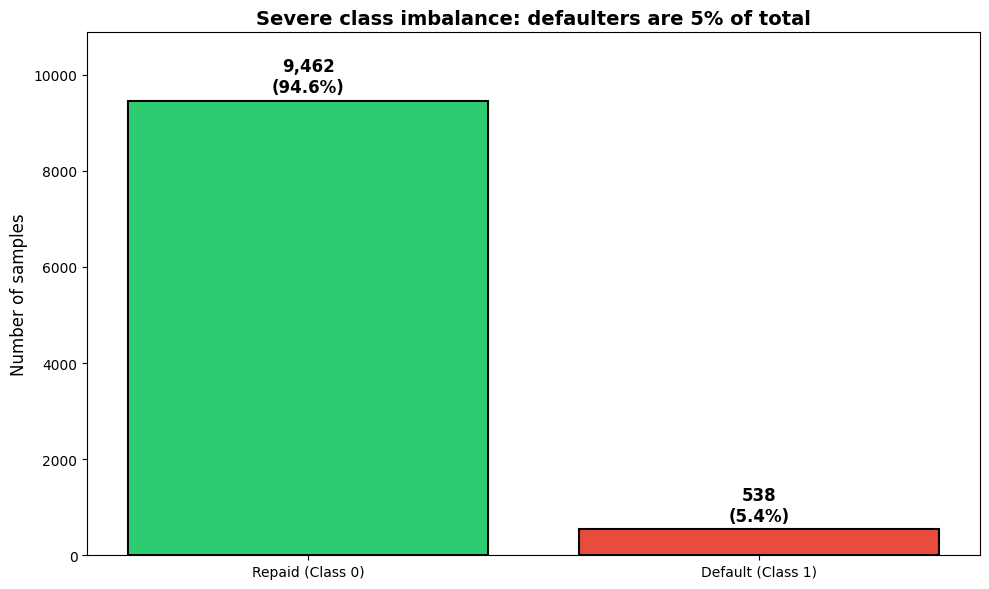

In [15]:
# Visualize class distribution
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#2ecc71', '#e74c3c']
labels = ['Repaid (Class 0)', 'Default (Class 1)']
bars = ax.bar(labels, counts, color=colors, edgecolor='black', linewidth=1.5)

# Show values
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
            f'{count:,}\n({count/len(y)*100:.1f}%)', 
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Number of samples', fontsize=12)
ax.set_title('Severe class imbalance: defaulters are 5% of total', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(counts) * 1.15)

plt.tight_layout()
plt.savefig('../output/Q2/class_imbalance.png', dpi=150, bbox_inches='tight')
plt.show()

In [16]:
# "Naive" model: predict everything as normal
y_pred_dummy = np.zeros_like(y)  # predict all as 0 (normal)

print("=" * 60)
print(f"\n Accuracy: {accuracy_score(y, y_pred_dummy):.1%}  ← looks very high!")
print(f" Precision (default): {precision_score(y, y_pred_dummy, zero_division=0):.1%}")
print(f" Recall (default): {recall_score(y, y_pred_dummy):.1%}  ← fails to find any defaulters!")
print(f" F1-Score (default): {f1_score(y, y_pred_dummy):.1%}")


 Accuracy: 94.6%  ← looks very high!
 Precision (default): 0.0%
 Recall (default): 0.0%  ← fails to find any defaulters!
 F1-Score (default): 0.0%


## 2. Appropriate Metrics: F1-Score and AUC-PR

### 2.1 Understanding the Confusion Matrix

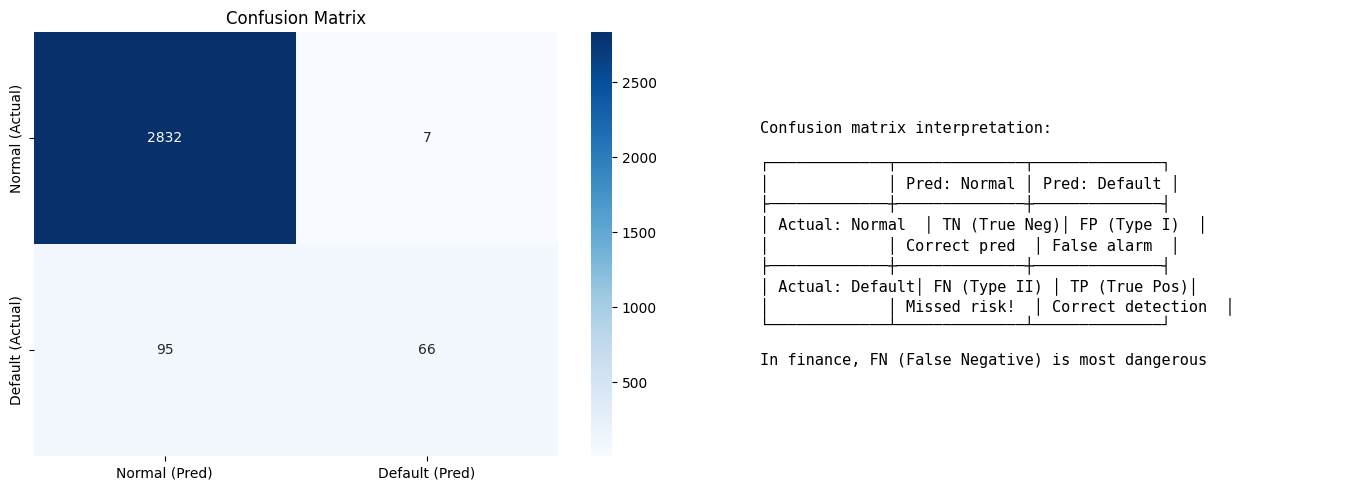

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Basic logistic regression (no imbalance handling)
lr_basic = LogisticRegression(random_state=42, max_iter=1000)
lr_basic.fit(X_train_scaled, y_train)
y_pred_basic = lr_basic.predict(X_test_scaled)
y_prob_basic = lr_basic.predict_proba(X_test_scaled)[:, 1]

# Visualize confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_basic)
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Normal (Pred)', 'Default (Pred)'],
            yticklabels=['Normal (Actual)', 'Default (Actual)'])
ax1.set_title('Confusion Matrix', fontsize=12)

# Interpreting the confusion matrix
ax2 = axes[1]
ax2.axis('off')
explanation = """
Confusion matrix interpretation:

┌─────────────┬──────────────┬──────────────┐
│             │ Pred: Normal │ Pred: Default │
├─────────────┼──────────────┼──────────────┤
│ Actual: Normal  │ TN (True Neg)│ FP (Type I)  │
│             │ Correct pred  │ False alarm  │
├─────────────┼──────────────┼──────────────┤
│ Actual: Default│ FN (Type II) │ TP (True Pos)│
│             │ Missed risk!  │ Correct detection  │
└─────────────┴──────────────┴──────────────┘

In finance, FN (False Negative) is most dangerous
"""
ax2.text(0.1, 0.5, explanation, fontsize=11, family='monospace',
         verticalalignment='center', transform=ax2.transAxes)

plt.tight_layout()
plt.savefig('../output/Q2/confusion_matrix_explained.png', dpi=150, bbox_inches='tight')
plt.show()

### 2.2 Precision, Recall, F1-Score

In [18]:
# Compute metrics and visualize
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn)

print("=" * 60)
print("Metric calculations")
print("=" * 60)
print(f"""
Precision = TP / (TP + FP)
                   = {tp} / ({tp} + {fp})
                   = {precision:.3f}

Recall = TP / (TP + FN)  
               = {tp} / ({tp} + {fn})
               = {recall:.3f}
F1-Score = 2 × (Precision × Recall) / (Precision + Recall)
         = 2 × ({precision:.3f} × {recall:.3f}) / ({precision:.3f} + {recall:.3f})
         = {f1:.3f}
""")

Metric calculations

Precision = TP / (TP + FP)
                   = 66 / (66 + 7)
                   = 0.904

Recall = TP / (TP + FN)  
               = 66 / (66 + 95)
               = 0.410
F1-Score = 2 × (Precision × Recall) / (Precision + Recall)
         = 2 × (0.904 × 0.410) / (0.904 + 0.410)
         = 0.564



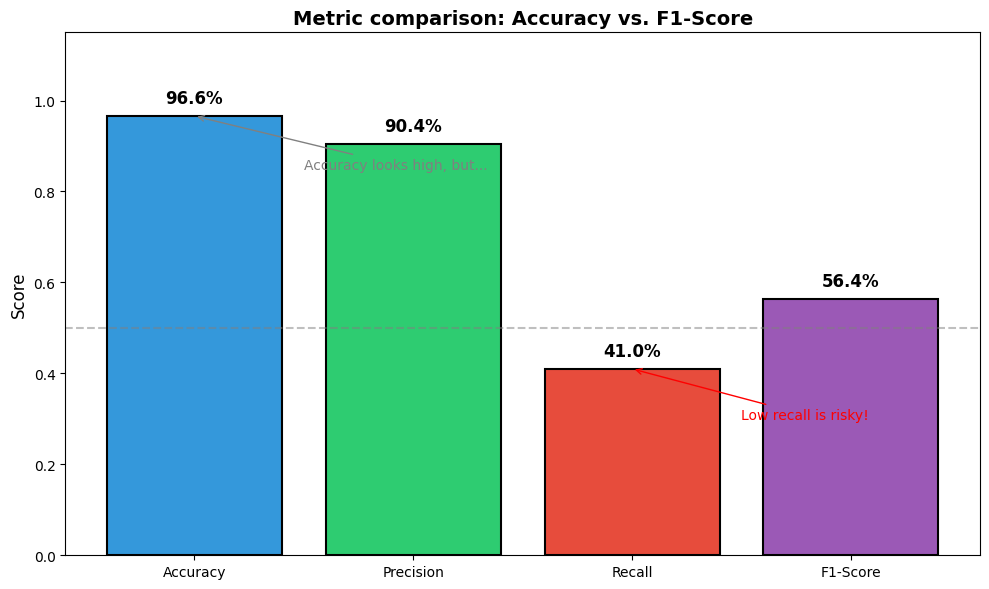

In [19]:
# Visualize metric comparison
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

bars = ax.bar(metrics, values, color=colors, edgecolor='black', linewidth=1.5)

for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.1%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylim(0, 1.15)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Metric comparison: Accuracy vs. F1-Score', fontsize=14, fontweight='bold')
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='random baseline')

# Add annotations
ax.annotate('Accuracy looks high, but...', xy=(0, accuracy), xytext=(0.5, 0.85),
            arrowprops=dict(arrowstyle='->', color='gray'),
            fontsize=10, color='gray')
ax.annotate('Low recall is risky!', xy=(2, recall), xytext=(2.5, 0.3),
            arrowprops=dict(arrowstyle='->', color='red'),
            fontsize=10, color='red')

plt.tight_layout()
plt.savefig('../output/Q2/metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### 2.3 AUC-PR vs AUC-ROC

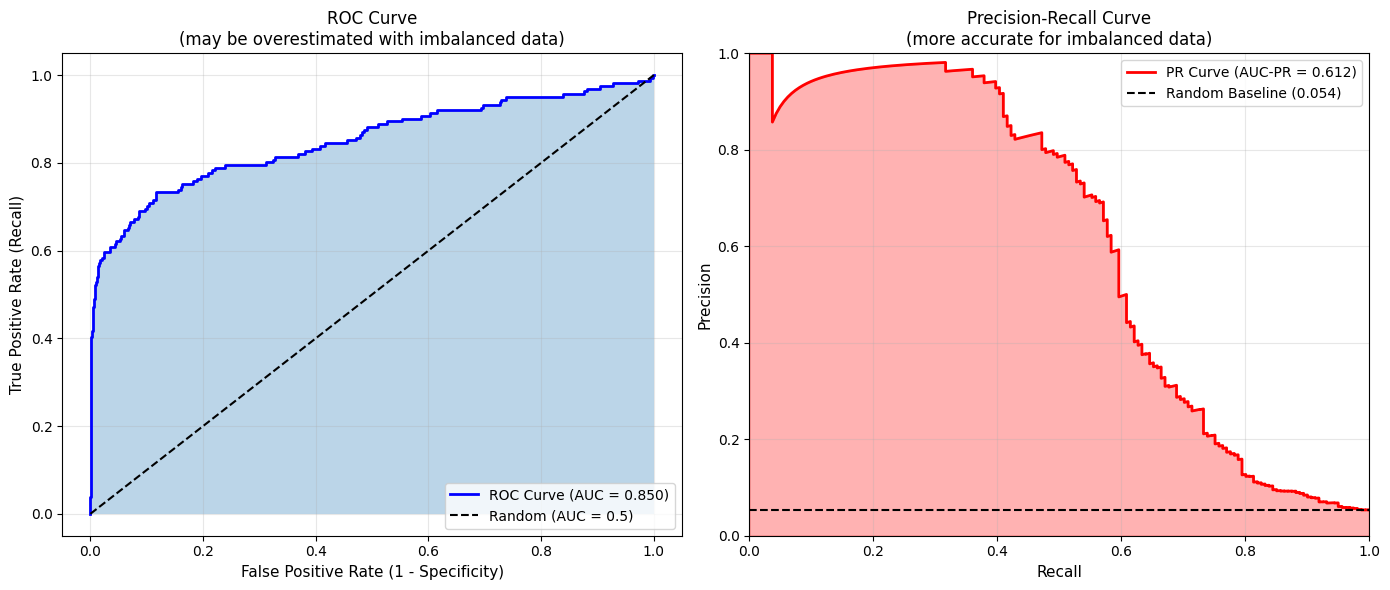

AUC-ROC vs AUC-PR comparison
AUC-ROC = 0.850,AUC-PR  = 0.612


In [20]:
# Compare PR and ROC curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
ax1 = axes[0]
fpr, tpr, _ = roc_curve(y_test, y_prob_basic)
roc_auc = roc_auc_score(y_test, y_prob_basic)

ax1.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
ax1.fill_between(fpr, tpr, alpha=0.3)
ax1.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=11)
ax1.set_ylabel('True Positive Rate (Recall)', fontsize=11)
ax1.set_title('ROC Curve\n(may be overestimated with imbalanced data)', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Precision-Recall Curve
ax2 = axes[1]
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob_basic)
pr_auc = average_precision_score(y_test, y_prob_basic)
baseline = np.sum(y_test) / len(y_test)  # default rate

ax2.plot(recall_curve, precision_curve, 'r-', linewidth=2, 
         label=f'PR Curve (AUC-PR = {pr_auc:.3f})')
ax2.axhline(y=baseline, color='k', linestyle='--', 
            label=f'Random Baseline ({baseline:.3f})')
ax2.fill_between(recall_curve, precision_curve, alpha=0.3, color='red')
ax2.set_xlabel('Recall', fontsize=11)
ax2.set_ylabel('Precision', fontsize=11)
ax2.set_title('Precision-Recall Curve\n(more accurate for imbalanced data)', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('../output/Q2/roc_vs_pr_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print("AUC-ROC vs AUC-PR comparison")
print(f"""AUC-ROC = {roc_auc:.3f},AUC-PR  = {pr_auc:.3f}""")

In [21]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("Original training data:")
print(f"  - Class 0 (Normal): {Counter(y_train)[0]:,}")
print(f"  - Class 1 (Default): {Counter(y_train)[1]:,}")

print("\nAfter SMOTE:")
print(f"  - Class 0 (Normal): {Counter(y_train_smote)[0]:,}")
print(f"  - Class 1 (Default): {Counter(y_train_smote)[1]:,} (synthetic samples)")

Original training data:
  - Class 0 (Normal): 6,623
  - Class 1 (Default): 377

After SMOTE:
  - Class 0 (Normal): 6,623
  - Class 1 (Default): 6,623 (synthetic samples)


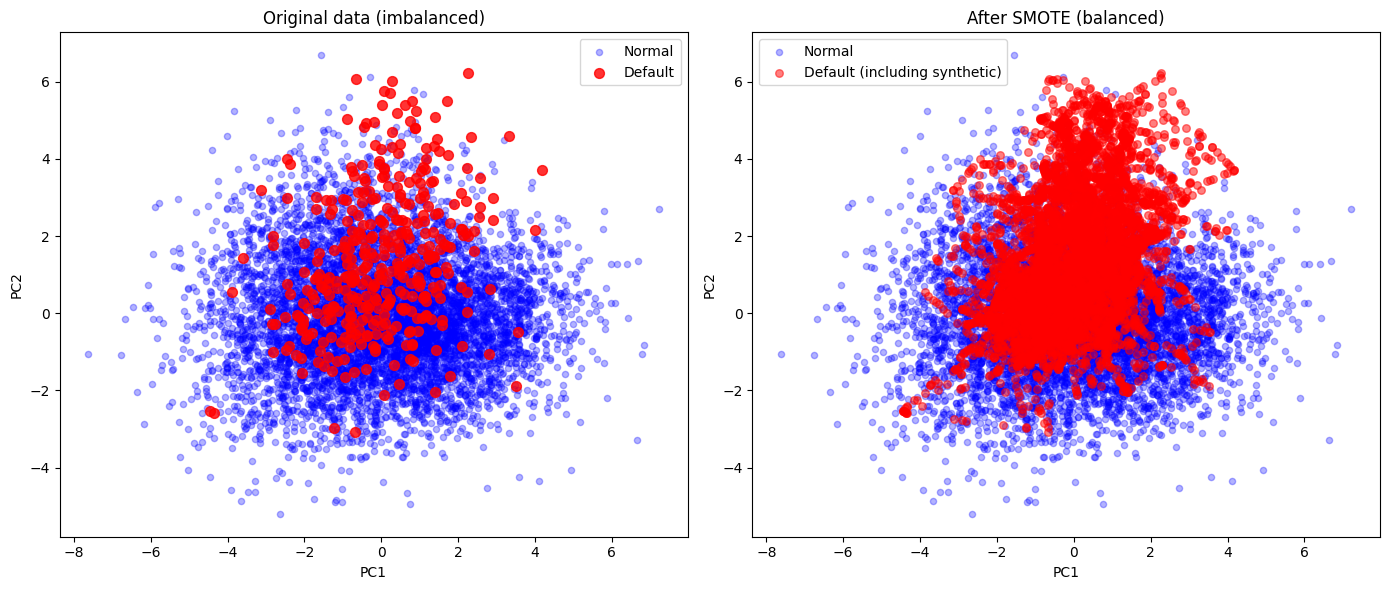

In [22]:
# Visualize SMOTE (2D projection)
from sklearn.decomposition import PCA

# 2D projection with PCA
pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(X_train_scaled)
X_train_smote_2d = pca.transform(X_train_smote)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original data
ax1 = axes[0]
ax1.scatter(X_train_2d[y_train==0, 0], X_train_2d[y_train==0, 1], 
            c='blue', alpha=0.3, label='Normal', s=20)
ax1.scatter(X_train_2d[y_train==1, 0], X_train_2d[y_train==1, 1], 
            c='red', alpha=0.8, label='Default', s=50)
ax1.set_title('Original data (imbalanced)', fontsize=12)
ax1.legend()
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

# After SMOTE
ax2 = axes[1]
ax2.scatter(X_train_smote_2d[y_train_smote==0, 0], X_train_smote_2d[y_train_smote==0, 1], 
            c='blue', alpha=0.3, label='Normal', s=20)
ax2.scatter(X_train_smote_2d[y_train_smote==1, 0], X_train_smote_2d[y_train_smote==1, 1], 
            c='red', alpha=0.5, label='Default (including synthetic)', s=30)
ax2.set_title('After SMOTE (balanced)', fontsize=12)
ax2.legend()
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')

plt.tight_layout()
plt.savefig('../output/Q2/smote_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.2 Performance Comparison of Three Methods

In [23]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer

# 1. Baseline model (no imbalance handling)
lr_basic = LogisticRegression(random_state=42, max_iter=1000)
lr_basic.fit(X_train_scaled, y_train)
y_pred_basic = lr_basic.predict(X_test_scaled)
y_prob_basic = lr_basic.predict_proba(X_test_scaled)[:, 1]

# 2. SMOTE model
lr_smote = LogisticRegression(random_state=42, max_iter=1000)
lr_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = lr_smote.predict(X_test_scaled)
y_prob_smote = lr_smote.predict_proba(X_test_scaled)[:, 1]

# 3. Cost-sensitive Learning (class_weight='balanced')
lr_weighted = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_weighted.fit(X_train_scaled, y_train)
y_pred_weighted = lr_weighted.predict(X_test_scaled)
y_prob_weighted = lr_weighted.predict_proba(X_test_scaled)[:, 1]

# Save results
results = {
    'Model': ['Baseline (no handling)', 'SMOTE', 'Cost-sensitive'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_basic),
        accuracy_score(y_test, y_pred_smote),
        accuracy_score(y_test, y_pred_weighted)
    ],
    'Precision': [
        precision_score(y_test, y_pred_basic),
        precision_score(y_test, y_pred_smote),
        precision_score(y_test, y_pred_weighted)
    ],
    'Recall': [
        recall_score(y_test, y_pred_basic),
        recall_score(y_test, y_pred_smote),
        recall_score(y_test, y_pred_weighted)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_basic),
        f1_score(y_test, y_pred_smote),
        f1_score(y_test, y_pred_weighted)
    ],
    'AUC-PR': [
        average_precision_score(y_test, y_prob_basic),
        average_precision_score(y_test, y_prob_smote),
        average_precision_score(y_test, y_prob_weighted)
    ]
}

results_df = pd.DataFrame(results)
print("Model performance comparison")
print(results_df.to_string(index=False))

Model performance comparison
                 Model  Accuracy  Precision   Recall  F1-Score   AUC-PR
Baseline (no handling)  0.966000   0.904110 0.409938  0.564103 0.611636
                 SMOTE  0.833667   0.212585 0.776398  0.333778 0.568436
        Cost-sensitive  0.824000   0.204509 0.788820  0.324808 0.566567


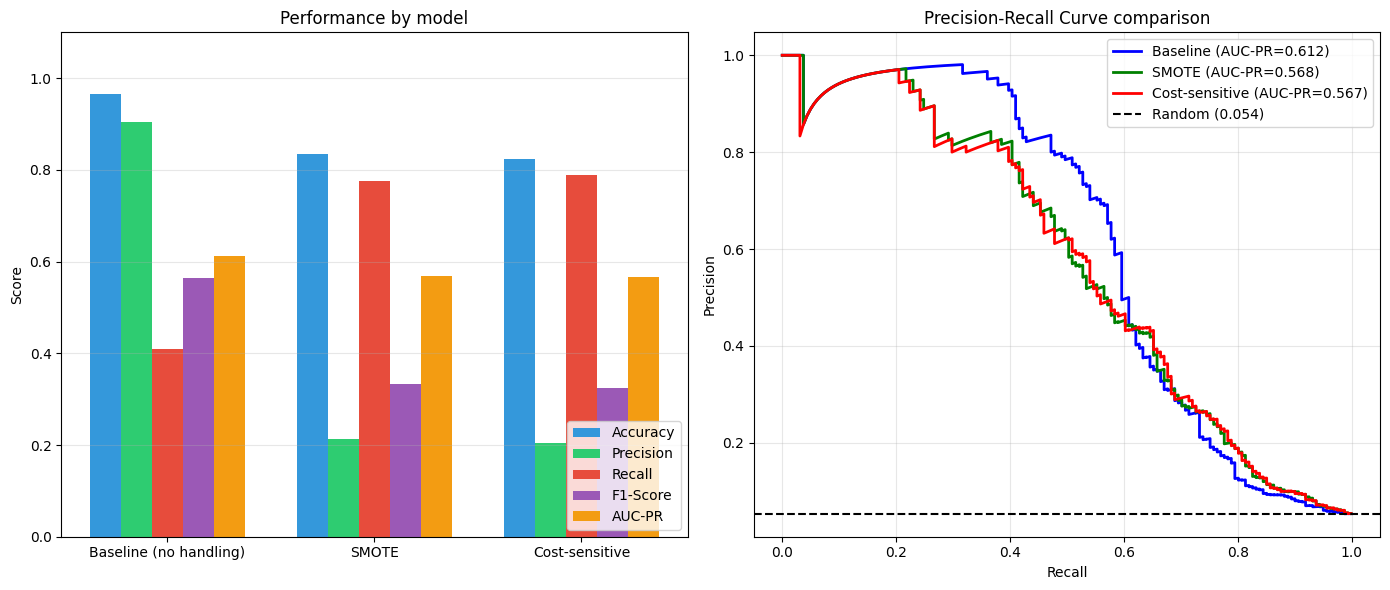

In [24]:
# Visualize performance comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Metric comparison bar chart
ax1 = axes[0]
x = np.arange(len(results['Model']))
width = 0.15

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-PR']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']

for i, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    ax1.bar(x + i*width, results[metric], width, label=metric, color=color)

ax1.set_ylabel('Score')
ax1.set_title('Performance by model', fontsize=12)
ax1.set_xticks(x + width*2)
ax1.set_xticklabels(results['Model'])
ax1.legend(loc='lower right')
ax1.set_ylim(0, 1.1)
ax1.grid(True, alpha=0.3, axis='y')

# Compare PR curves
ax2 = axes[1]

for name, y_prob, color in [('Baseline', y_prob_basic, 'blue'), 
                             ('SMOTE', y_prob_smote, 'green'),
                             ('Cost-sensitive', y_prob_weighted, 'red')]:
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    ax2.plot(rec, prec, label=f'{name} (AUC-PR={ap:.3f})', linewidth=2, color=color)

baseline = np.sum(y_test) / len(y_test)
ax2.axhline(y=baseline, color='k', linestyle='--', label=f'Random ({baseline:.3f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve comparison', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/Q2/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.3 Robustness Test

In [25]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline

# Robustness test via cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# SMOTE Pipeline
smote_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Cost-sensitive Model
weighted_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# Cross-validated F1 scores
print("Cross-validation robustness test (10 repeats, 5-fold)")

f1_scorer = make_scorer(f1_score)

# SMOTE performance
smote_scores = cross_val_score(smote_pipeline, X_train_scaled, y_train, cv=cv, scoring=f1_scorer)
print(f"\nSMOTE:")
print(f"  F1 mean: {smote_scores.mean():.4f}")
print(f"  F1 std: {smote_scores.std():.4f}")
print(f"  CV: {smote_scores.std()/smote_scores.mean()*100:.1f}%")

# Cost-sensitive performance
weighted_scores = cross_val_score(weighted_model, X_train_scaled, y_train, cv=cv, scoring=f1_scorer)
print(f"\nCost-sensitive:")
print(f"  F1 mean: {weighted_scores.mean():.4f}")
print(f"  F1 std: {weighted_scores.std():.4f}")
print(f"  CV: {weighted_scores.std()/weighted_scores.mean()*100:.1f}%")

Cross-validation robustness test (10 repeats, 5-fold)

SMOTE:
  F1 mean: 0.3347
  F1 std: 0.0195
  CV: 5.8%

Cost-sensitive:
  F1 mean: 0.3233
  F1 std: 0.0172
  CV: 5.3%


<positron-console-cell-26>:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


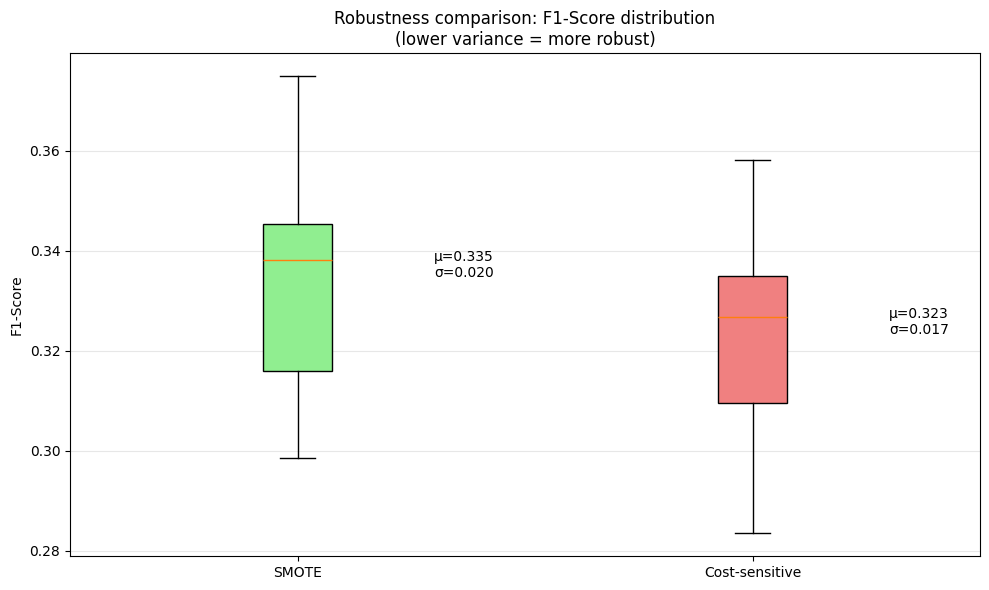

In [26]:
# Visualize robustness
fig, ax = plt.subplots(figsize=(10, 6))

data_to_plot = [smote_scores, weighted_scores]
bp = ax.boxplot(data_to_plot, labels=['SMOTE', 'Cost-sensitive'], patch_artist=True)

colors = ['lightgreen', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('F1-Score')
ax.set_title('Robustness comparison: F1-Score distribution\n(lower variance = more robust)', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

# Add statistics
for i, (scores, name) in enumerate([(smote_scores, 'SMOTE'), (weighted_scores, 'Cost-sensitive')]):
    ax.annotate(f'μ={scores.mean():.3f}\nσ={scores.std():.3f}', 
                xy=(i+1.3, scores.mean()), fontsize=10)

plt.tight_layout()
plt.savefig('../output/Q2/robustness_comparison.png', dpi=150, bbox_inches='tight')
plt.show()